# Machine Learning Analysis of Student Achievements in England

## Importing Necessary Libraries

In [1]:
import matplotlib.pyplot as plt  # Charting and visualisation
import numpy as np  # Handling arrays
import pandas as pd  # Data manipulation and handling
import seaborn as sns  # Charting and visualisation
from sklearn.cluster import KMeans  # Clustering model
from sklearn.decomposition import PCA  # Dimensionality reduction
from sklearn.ensemble import RandomForestRegressor  # Random Forest model
from sklearn.model_selection import (
    GridSearchCV,  # Hyperparameter tuning
    RepeatedKFold,  # Cross-validation
    cross_val_score,  # Cross-validation scores
    train_test_split,  # Training and testing data splitting
)
from sklearn.preprocessing import OneHotEncoder, RobustScaler  # Data preprocessing
from sklearn.svm import LinearSVR  # Support Vector Regression model
from sklearn.tree import plot_tree  # Decision tree visualisation

## Data Retrieval

Read 'fes-geography-population-202324-q2.csv' as DataFrame 'fes_df'.

In [ ]:
fes_df = pd.read_csv("fes-geography-population-202324-q2.csv")

Previewing 'fes_df' showed the data import was successful.

In [3]:
fes_df.head()

,time_period,time_identifier,geographic_level,country_code,country_name,region_code,region_name,new_la_code,old_la_code,la_name,...,provision_type,level_or_type,age_summary,starts,participation,achievements,population_estimate,starts_rate_per_100000_population,participation_rate_per_100000_population,achievements_rate_per_100000_population
0,202324,Academic year,National,E92000001,England,NaN,NaN,NaN,NaN,NaN,...,Further education and skills,Further education and skills: Total,Total,z,1308800,424270,33932186,z,3857,1250
1,202324,Academic year,National,E92000001,England,NaN,NaN,NaN,NaN,NaN,...,Further education and skills,Further education and skills: Total,19-24,z,365550,79660,4094484,z,8928,1946
2,202324,Academic year,National,E92000001,England,NaN,NaN,NaN,NaN,NaN,...,Further education and skills,Further education and skills: Total,25+,z,943250,344610,29837702,z,3161,1155
3,202324,Academic year,National,E92000001,England,NaN,NaN,NaN,NaN,NaN,...,Further education and skills,Further education and skills: Level 2,Total,z,341900,95030,33932186,z,1008,280
4,202324,Academic year,National,E92000001,England,NaN,NaN,NaN,NaN,NaN,...,Further education and skills,Further education and skills: Level 2,19-24,z,96730,21020,4094484,z,2362,513


## Data Cleaning

Displayed the shape of 'fes_df', this correctly matches 'fes-geography-population-202324-q2.csv'.

In [4]:
fes_df.shape

(584998, 30)

Dropped columns designated as unnecessary.

In [5]:
fes_df = fes_df.drop(
    columns=[
        "time_identifier",  # Only value is 'Academic year'
        "country_code",  # Only country is England
        "country_name",  # Only country is England
        "region_code",  # Already have region name
        "new_la_code",  # Already have local authority name
        "old_la_code",  # Already have local authority name
        "lad_code",  # Already have local authority district name
        "pcon_code",  # Already have parliamentary constituency name
        "english_devolved_area_code",  # Already have english devolved area name
        "local_enterprise_partnership_code",  # Already have partnership name
        "lsip_code",  # Already have lsip name
        "starts",  # Only applies to apprenticeships
        "starts_rate_per_100000_population",  # Only applies to apprenticeships
        "participation_rate_per_100000_population",  # Already have participation
        "achievements_rate_per_100000_population",  # Already have achievements
    ]
)

Displayed DataFrame information for 'fes_df'. Many columns have NaN values. Columns 'participation', 'achievements', and 'population_estimate' are of type object, these were expected to be numeric.

In [6]:
fes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584998 entries, 0 to 584997
Data columns (total 15 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   time_period                        584998 non-null  int64 
 1   geographic_level                   584998 non-null  object
 2   region_name                        257878 non-null  object
 3   la_name                            83960 non-null   object
 4   lad_name                           168398 non-null  object
 5   pcon_name                          291736 non-null  object
 6   english_devolved_area_name         6624 non-null    object
 7   local_enterprise_partnership_name  20944 non-null   object
 8   lsip_name                          7264 non-null    object
 9   provision_type                     584998 non-null  object
 10  level_or_type                      584998 non-null  object
 11  age_summary                        584998 non-null  

The expected numeric columns contained some non-numeric characters, as highlighted in the provided 'data-guidance.txt' file, explaining why these were of type object. These non-numeric characters were replaced with 0 and the columns converted to numeric.

In [7]:
def non_numeric_to_zero(df, col):
    """
    Fills non-numeric characters with 0.

        Parameters:
            df: Pandas DataFrame
            col: DataFrame column

        Returns:
            Dataframe column with non-numeric characters replaced with 0.
    """
    df[col] = pd.to_numeric(
        df[col], errors="coerce"
    )  # Converts col to numeric, errors filled with NaN
    df[col] = df[col].fillna(0)  # All NaNs replaced with zero
    return df


# Expected numeric columns
num_cols = ["participation", "achievements", "population_estimate"]

# Execute non_numeric_to_zero on num_cols
for col in num_cols:
    fes_df = non_numeric_to_zero(fes_df, col)

Reprinting the column types showed the expected numeric columns were successfully converted to numeric.

In [8]:
fes_df.dtypes

time_period                            int64
geographic_level                      object
region_name                           object
la_name                               object
lad_name                              object
pcon_name                             object
english_devolved_area_name            object
local_enterprise_partnership_name     object
lsip_name                             object
provision_type                        object
level_or_type                         object
age_summary                           object
participation                        float64
achievements                         float64
population_estimate                  float64
dtype: object

Checked for duplicate rows. None were found.

In [9]:
fes_df.duplicated().sum()

0

Upon closer inspection of the NaNs, these were due to different groupings of geographic levels. In other words, filtering by one 'geographic_level' would result in NaN values for other geographic levels. For example, filtering by 'English devolved area' results in NaNs for 'region_name'. Therefore no real NaNs exist.

In [10]:
for level in fes_df.geographic_level.unique():
    # Filter by each geographic_level
    geo_levels_df = fes_df[fes_df.geographic_level == level]
    # Print geographic_level and NaN values
    print(f"\nGeographic level: {level}\n")
    print(geo_levels_df.isna().sum())


Geographic level: National

time_period                            0
geographic_level                       0
region_name                          552
la_name                              552
lad_name                             552
pcon_name                            552
english_devolved_area_name           552
local_enterprise_partnership_name    552
lsip_name                            552
provision_type                         0
level_or_type                          0
age_summary                            0
participation                          0
achievements                           0
population_estimate                    0
dtype: int64

Geographic level: Regional

time_period                             0
geographic_level                        0
region_name                             0
la_name                              5520
lad_name                             5520
pcon_name                            5520
english_devolved_area_name           5520
local_enterprise_par

Renamed columns for improved interpretability.

In [11]:
# Create column renaming dictionary
col_rename_dict = {
    "time_period": "Academic Year",
    "geographic_level": "Geographic Level",
    "region_name": "Region",
    "la_name": "Local Authority",
    "lad_name": "Local Authority District",
    "pcon_name": "Parliamentary Constituency",
    "english_devolved_area_name": "English Devolved Area",
    "local_enterprise_partnership_name": "Enterprise Partnership",
    "lsip_name": "Local Skills Improvement Plan",
    "provision_type": "Provision Type",
    "level_or_type": "Level or Type",
    "age_summary": "Age Group",
    "starts": "Starts",
    "participation": "Participation",
    "achievements": "Achievements",
    "population_estimate": "Population Estimate",
}

# Rename columns using col_rename_dict
fes_df.rename(columns=col_rename_dict, inplace=True)

## Exploratory Data Analysis (EDA)

Created DataFrame 'la_fes_df' by filtering 'fes_df' by local authority, as this geographic level provides sufficient data size and granularity.

In [12]:
la_fes_df = fes_df[
    # Filter by local authority
    (fes_df["Geographic Level"] == "Local authority")
    & (
        # Exlude total rows to avoid double counting
        ~fes_df["Level or Type"].isin(
            [
                "Apprenticeships: Total",
                "Community learning: Total",
                "Education and training: Total",
                "Further education and skills: Total",
            ]
        )
    )
    # Exlude total rows to avoid double counting
    & (fes_df["Age Group"] != "Total")
]

### Categorical Columns Analysis

Printed the number of unique values for each categorical column in 'la_fes_df'. Some columns had either 0 or too many unique values for further analysis.

In [13]:
# Categorical columns
cat_cols = [
    "Academic Year",
    "Geographic Level",
    "Region",
    "Local Authority",
    "Local Authority District",
    "Parliamentary Constituency",
    "English Devolved Area",
    "Enterprise Partnership",
    "Local Skills Improvement Plan",
    "Provision Type",
    "Level or Type",
    "Age Group",
]

# Print count of unique values for cat_cols
for col in cat_cols:
    print(f"{col}: {la_fes_df[col].nunique()}")

Academic Year: 6
Geographic Level: 1
Region: 10
Local Authority: 156
Local Authority District: 0
Parliamentary Constituency: 0
English Devolved Area: 0
Enterprise Partnership: 0
Local Skills Improvement Plan: 0
Provision Type: 4
Level or Type: 30
Age Group: 3


Dropped the columns with too few or many groups.

In [14]:
la_fes_df = la_fes_df.drop(
    columns=[
        "Geographic Level",
        "Local Authority",
        "Local Authority District",
        "Parliamentary Constituency",
        "English Devolved Area",
        "Enterprise Partnership",
        "Local Skills Improvement Plan",
        "Level or Type",
    ]
)

cat_cols = [
    "Academic Year",
    "Region",
    "Provision Type",
    "Age Group",
]

Created custom colour palette for charting.

In [15]:
col_pal = {"blue": "#003C86", "pink": "#EF0096", "green": "#00E307", "red": "#F60239"}

Generated count plots for the values of the categorical columns. The groups were mostly well-distributed, except for the region 'Outside of England and unknown,' which had few values and was considered irrelevant.

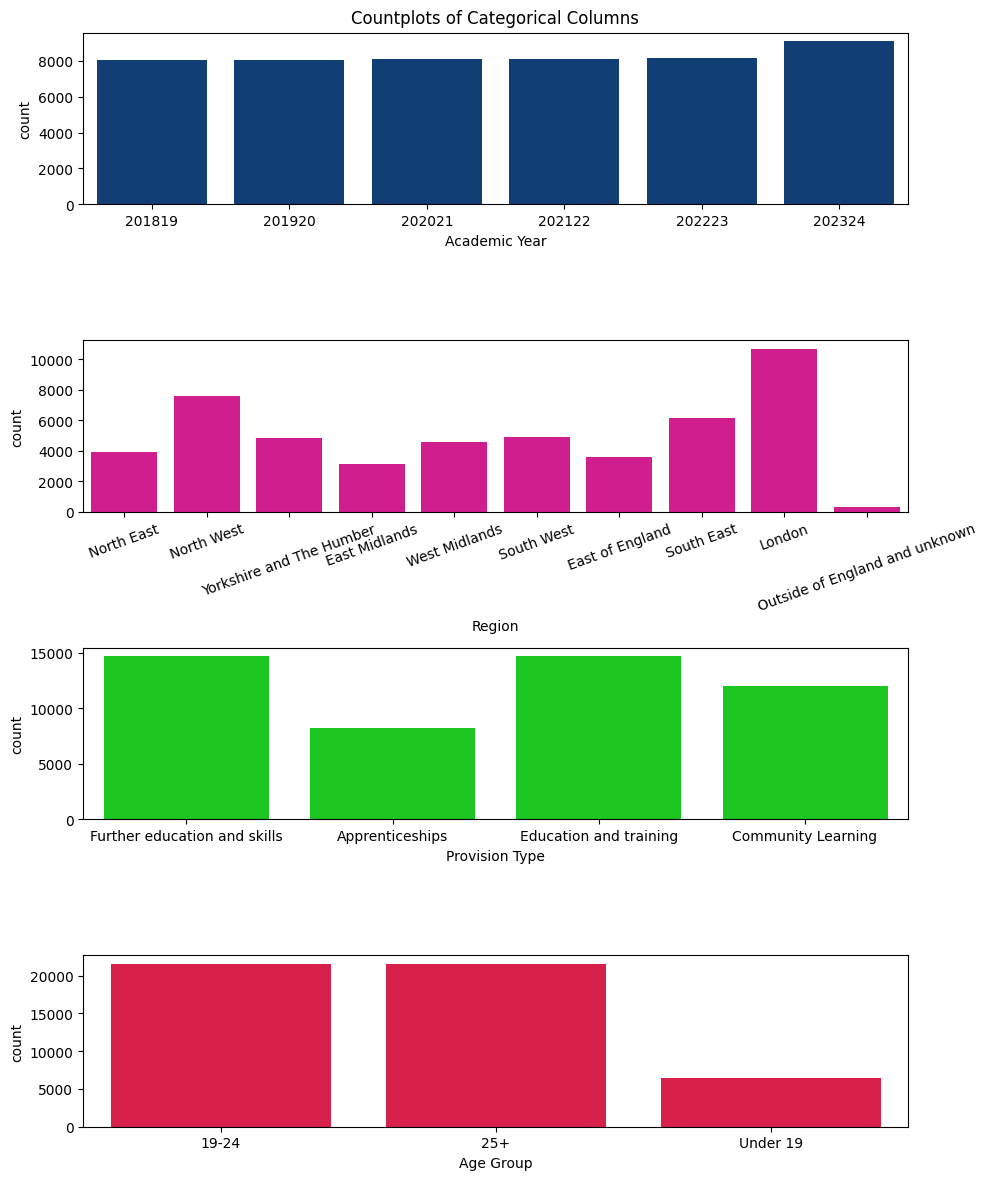

In [16]:
# Create subplots
fig, ax = plt.subplots(4, 1, figsize=(10, 12))

# Create count plots
sns.countplot(x="Academic Year", data=la_fes_df, ax=ax[0], color=col_pal["blue"])
sns.countplot(x="Region", data=la_fes_df, ax=ax[1], color=col_pal["pink"])
sns.countplot(x="Provision Type", data=la_fes_df, ax=ax[2], color=col_pal["green"])
sns.countplot(x="Age Group", data=la_fes_df, ax=ax[3], color=col_pal["red"])

# Rotate x labels 20 degrees
ax[1].tick_params(axis="x", rotation=20)

# Add title
plt.suptitle("Countplots of Categorical Columns")

# Display plot
plt.tight_layout()
plt.show()

Dropped rows with 'Outside of England and unknown'.

In [17]:
la_fes_df = la_fes_df[la_fes_df["Region"] != "Outside of England and unknown"]

### Numeric Columns Analysis

Printed the descriptive statistics of the numeric columns for the 'la_fes_df'.

In [18]:
la_fes_df.describe()

,Academic Year,Participation,Achievements,Population Estimate
count,49269.000000,49269.000000,49269.000000,49269.000000
mean,202077.181493,598.778542,328.623069,98101.825529
std,174.256047,962.616284,693.065452,127378.438347
min,201819.000000,0.000000,0.000000,28.000000
25%,201920.000000,50.000000,20.000000,16006.000000
50%,202122.000000,270.000000,100.000000,44810.000000
75%,202223.000000,730.000000,310.000000,138965.000000
max,202324.000000,17540.000000,13120.000000,812460.000000


Created a correlation heatmap to show the correlations between the numeric columns.

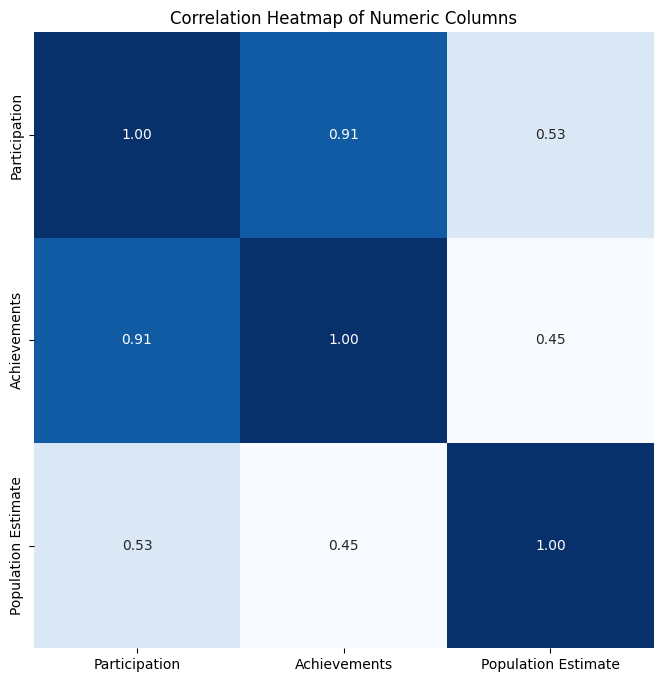

In [19]:
# Create correlation matrix
cor_mtx = la_fes_df[["Participation", "Achievements", "Population Estimate"]].corr()

# Plot correlation heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(cor_mtx, annot=True, fmt=".2f", cmap="Blues", cbar=False)

# Add title
plt.title("Correlation Heatmap of Numeric Columns")

# Display plot
plt.show()

Generated boxplots to show the distribution of the numeric columns.

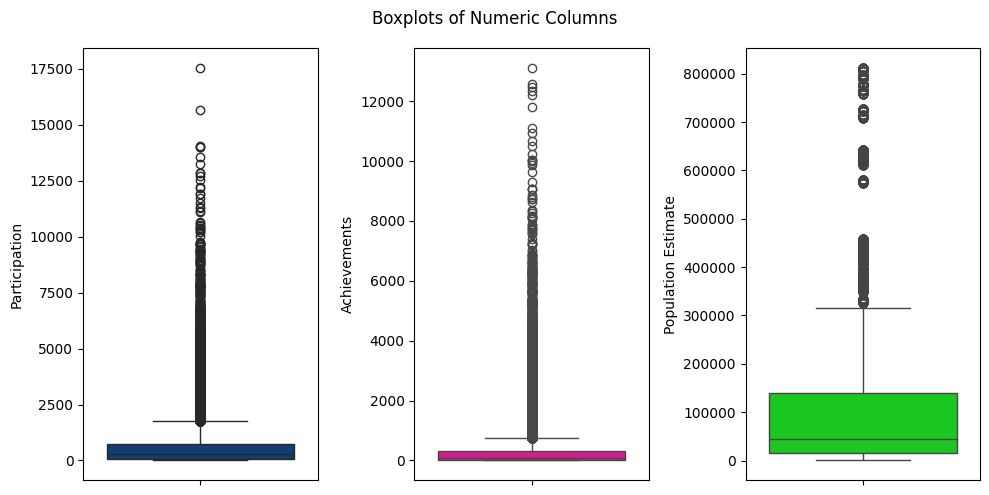

In [20]:
# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

# Plot boxplots
sns.boxplot(la_fes_df["Participation"], ax=ax[0], color=col_pal["blue"])
sns.boxplot(la_fes_df["Achievements"], ax=ax[1], color=col_pal["pink"])
sns.boxplot(la_fes_df["Population Estimate"], ax=ax[2], color=col_pal["green"])

# Add title
plt.suptitle("Boxplots of Numeric Columns")

# Display plot
plt.tight_layout()
plt.show()

Created pair plots to show the relationships between the numeric columns.

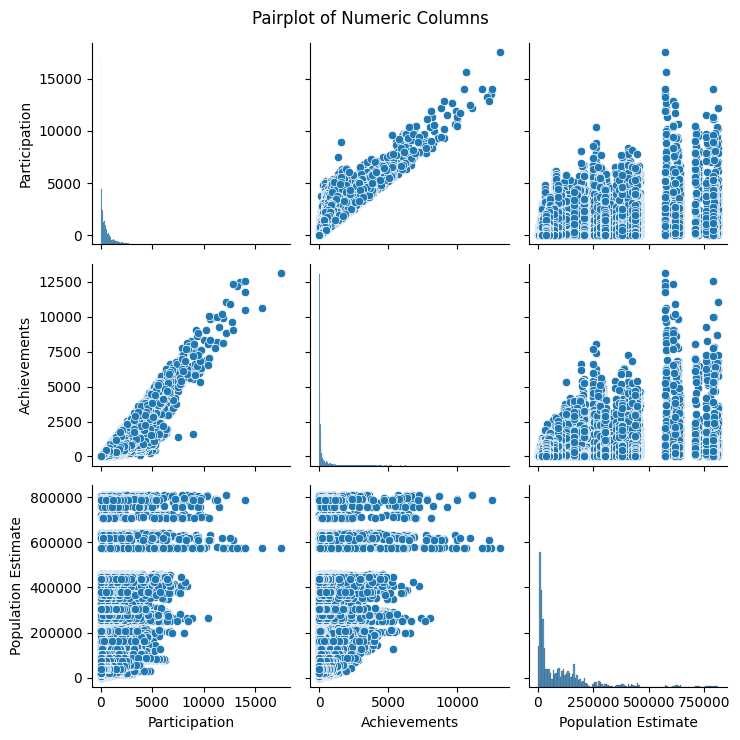

In [21]:
# Create pair plot
sns.pairplot(la_fes_df[["Participation", "Achievements", "Population Estimate"]])

# Add title
plt.suptitle("Pairplot of Numeric Columns")

# Display plot
plt.tight_layout()
plt.show()

Generated histograms to compare the distribution of the numeric columns.

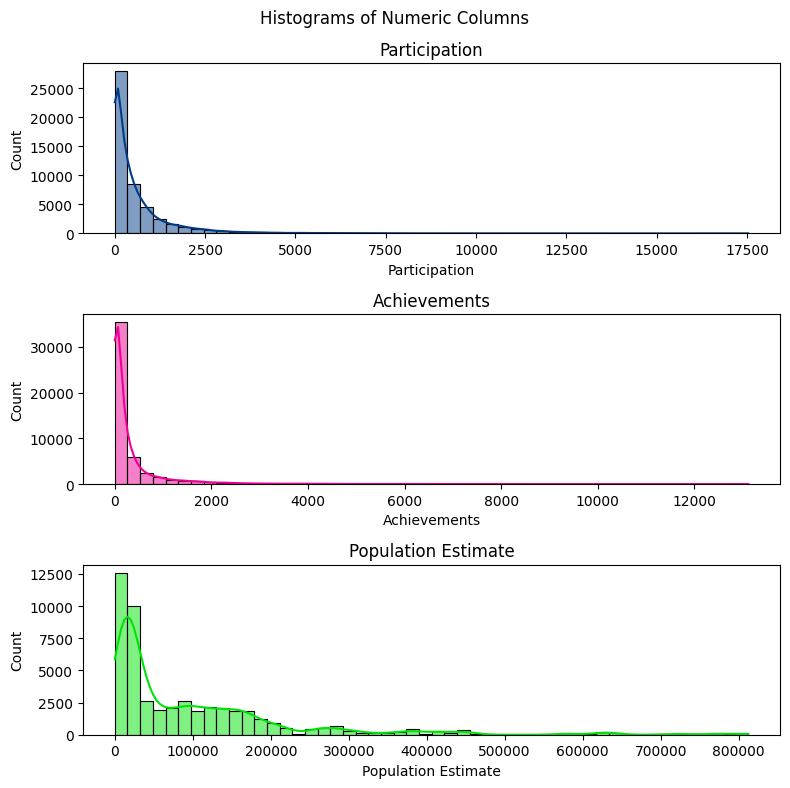

In [22]:
# Create subplots
fig, ax = plt.subplots(3, 1, figsize=(8, 8))

# Plot histograms
sns.histplot(
    la_fes_df["Participation"], bins=50, ax=ax[0], color=col_pal["blue"], kde=True
)
sns.histplot(
    la_fes_df["Achievements"], bins=50, ax=ax[1], color=col_pal["pink"], kde=True
)
sns.histplot(
    la_fes_df["Population Estimate"],
    bins=50,
    ax=ax[2],
    color=col_pal["green"],
    kde=True,
)

# Add titles
ax[0].set_title("Participation")
ax[1].set_title("Achievements")
ax[2].set_title("Population Estimate")
plt.suptitle("Histograms of Numeric Columns")

# Display plot
plt.tight_layout()
plt.show()

## Machine Learning Modelling

### Data Preprocessing

Encoded the categorical columns using OneHotEncoder to make them suitable for machine learning modelling

In [23]:
# Create instance of OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Encode cat_cols
cat_cols_encoded = encoder.fit_transform(la_fes_df[cat_cols])

# Create DataFrame of encoded cat_cols
cat_cols_encoded_df = pd.DataFrame(
    cat_cols_encoded, columns=encoder.get_feature_names_out(cat_cols)
)

# Reset the indexes to align the DataFrames
cat_cols_encoded_df.reset_index(drop=True, inplace=True)
la_fes_df.reset_index(drop=True, inplace=True)

# Recombine encoded cat_cols with numeric columns
la_fes_df_encoded = pd.concat(
    [
        cat_cols_encoded_df,
        la_fes_df[["Participation", "Achievements", "Population Estimate"]],
    ],
    axis=1,
)

Created features as 'X' using all attributes except 'Achievements'. Created target as 'y' using 'Achievements'.

In [24]:
X = la_fes_df_encoded.drop("Achievements", axis=1)
y = la_fes_df_encoded["Achievements"]

Split 'X' and 'y' into training and testing sets using the default ratio of 75% for training and 25% for testing. Then, scaled 'X' and 'y' using RobustScaler, due to its robustness to outliers, thereby effectively handling the right-skewed numeric data.

In [25]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Scale X and y
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Support Vector Regression Model

Created a Linear Support Vector Regression model to predict student achievements. Performed a grid search to select the optimal values for the 'C' regularisation strength and 'epsilon' hyperparameters. Used RepeatedKFold for cross-validation. 

In [26]:
# Create LinearSVR model
svr_test = LinearSVR(random_state=0)

# Use repeated k-fold for cross-validation
repeat_kfold = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)

# Define parameters to test for SVR
svr_params = {
    "C": [0.1, 1, 10],  # Regularisation
    "epsilon": [0.1, 0.2, 0.3],  # Epsilon
}

# Perform grid search with cross-validation to find best parameters
svr_grid = GridSearchCV(
    estimator=svr_test, param_grid=svr_params, cv=repeat_kfold, scoring="r2"
)

# Fit the model
svr_grid.fit(X_train_scaled, y_train)

# Print best parameters and R2 score
print("Best parameters for SVR:", svr_grid.best_params_)
print(f"R2 Score for best parameters: {svr_grid.best_score_}")

Best parameters for SVR: {'C': 1, 'epsilon': 0.1}
R2 Score for best parameters: 0.847747413067355


'C'= 1 and 'epsilon' = 0.1 were identified as the best values for these hyperparameters. Attempted to reduce the model complexity using PCA to reduce the number of features. However this resulted in greatly decreased performance. Therefore, PCA was not used in the final SVR model.

In [27]:
# Use PCA on the features to reduce dimensionality
X_train_pca = PCA(n_components=1).fit_transform(X_train_scaled)

# Create LinearSVR model using X_train_pca
svr_pca = LinearSVR(C=1, epsilon=0.1, random_state=0)

# Fit the model
svr_pca.fit(X_train_pca, y_train)

# Cross validate the model
scores = cross_val_score(svr_pca, X_train_pca, y_train, cv=repeat_kfold, scoring="r2")

# Print R2 score
print(f"R2 Score with PCA: {scores.mean()}")

R2 Score with PCA: 0.6188780712915964


The final SVR model was created with the optimal values for the 'C' and 'epsilon' hyperparameters, and without using PCA.

R2: 0.847747413067355
Mean squared error: -71081.29809223866
Root mean squared error: -266.5582619564864
Mean absolute error: -131.61478902759623


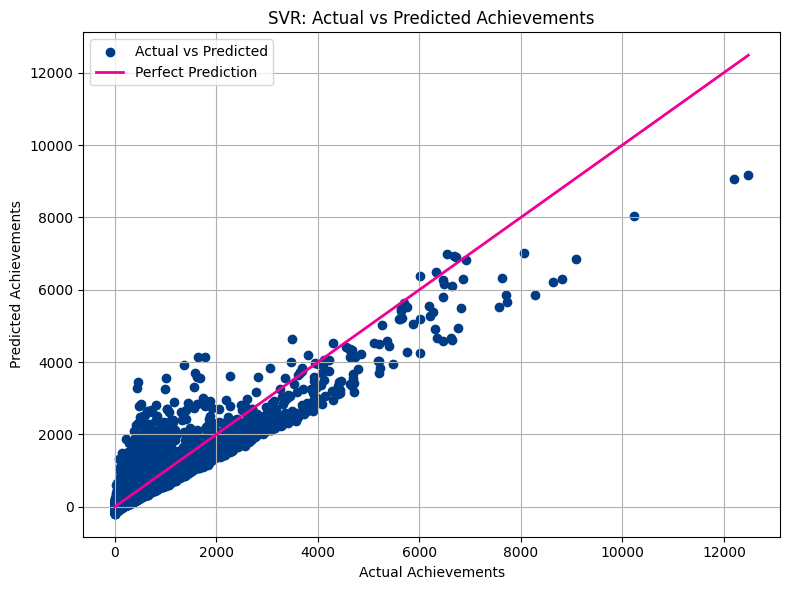

In [28]:
# Define regression metrics dictionary
regr_metrics = {
    "r2": "R2",
    "neg_mean_squared_error": "Mean squared error",
    "neg_root_mean_squared_error": "Root mean squared error",
    "neg_mean_absolute_error": "Mean absolute error",
}

# Create final LinearSVR model
svr_final = LinearSVR(C=1, epsilon=0.1, random_state=0)

# Cross validate the model with regr_metrics
for name, metric in regr_metrics.items():
    scores = cross_val_score(
        svr_final, X_train_scaled, y_train, cv=repeat_kfold, scoring=name
    )
    print(f"{metric}: {scores.mean()}")

# Fit the model
svr_final.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = svr_final.predict(X_test_scaled)

# Plot actual vs predicted achievements 
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color=col_pal["blue"], label="Actual vs Predicted")

# Plot perfect prediction line
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    col_pal["pink"],
    linewidth=2,
    label="Perfect Prediction",
)

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Add axis labels
plt.xlabel("Actual Achievements")
plt.ylabel("Predicted Achievements")

# Add title
plt.title("SVR: Actual vs Predicted Achievements")

# Display plot
plt.tight_layout()
plt.show()

### Random Forest Regression Model

Created a Random Forest model to predict student achievements. Performed a grid search to identify the optimal values for the 'n_estimators', 'max_depth', 'min_samples_split', and 'min_samples_leaf' hyperparameters. Used RepeatedKFold for cross-validation.

In [29]:
# Create Random Forest model
rf_test = RandomForestRegressor(random_state=0)

# Define parameters to test for Random Forest
rf_params = {
    "n_estimators": [10, 50, 100],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

# Perform grid search with cross-validation to find best parameters
rf_grid = GridSearchCV(
    estimator=rf_test,
    param_grid=rf_params,
    cv=repeat_kfold,
    scoring="r2",
    n_jobs=-2,  # Use all but 1 CPU core for efficiency
)

# Fit the model
rf_grid.fit(X_train_scaled, y_train)

# Print best parameters and R2 score
print("Best parameters for Random Forest:", rf_grid.best_params_)
print(f"R2 Score for best parameters: {rf_grid.best_score_}")

Best parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
R2 Score for best parameters: 0.9395309735417205


The final Random Forest model was created with the optimal values for the 'n_estimators', 'max_depth', 'min_samples_split', and 'min_samples_leaf' hyperparameters.

R2: 0.9395309735417205
Mean squared error: -28253.215072083276
Root mean squared error: -167.93164451661403
Mean absolute error: -67.34283841807527


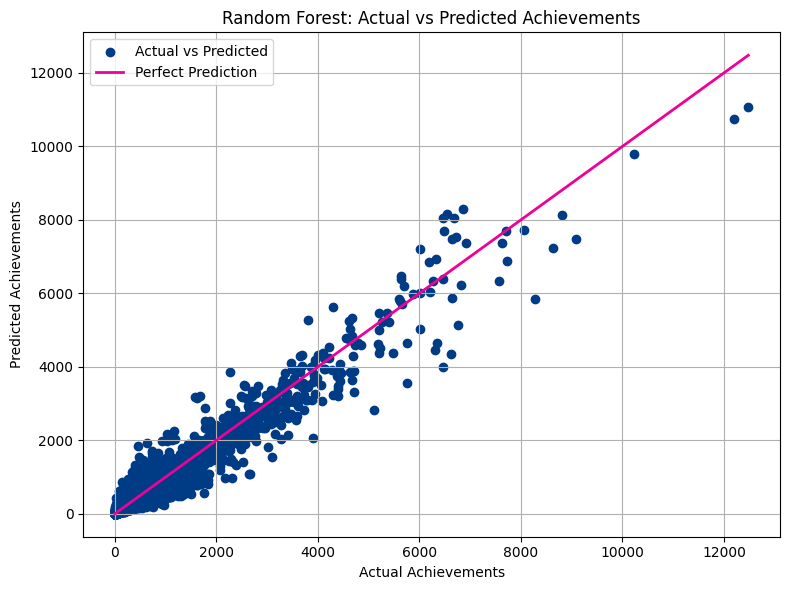

In [30]:
# Create final Random Forest model
rf_final = RandomForestRegressor(
    max_depth=10,
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=100,
    n_jobs=-2,  # Use all but 1 CPU core for efficiency
    random_state=0,
)

# Cross validate the model with regr_metrics
for name, metric in regr_metrics.items():
    scores = cross_val_score(
        rf_final, X_train_scaled, y_train, cv=repeat_kfold, scoring=name
    )
    print(f"{metric}: {scores.mean()}")

# Fit the model
rf_final.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = rf_final.predict(X_test_scaled)

# Plot actual vs predicted achievements
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color=col_pal["blue"], label="Actual vs Predicted")

# Plot perfect prediction line
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    col_pal["pink"],
    linewidth=2,
    label="Perfect Prediction",
)

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Add axis labels
plt.xlabel("Actual Achievements")
plt.ylabel("Predicted Achievements")

# Add title
plt.title("Random Forest: Actual vs Predicted Achievements")

# Display plot
plt.tight_layout()
plt.show()

Visualised the first tree from the final Random Forest model.

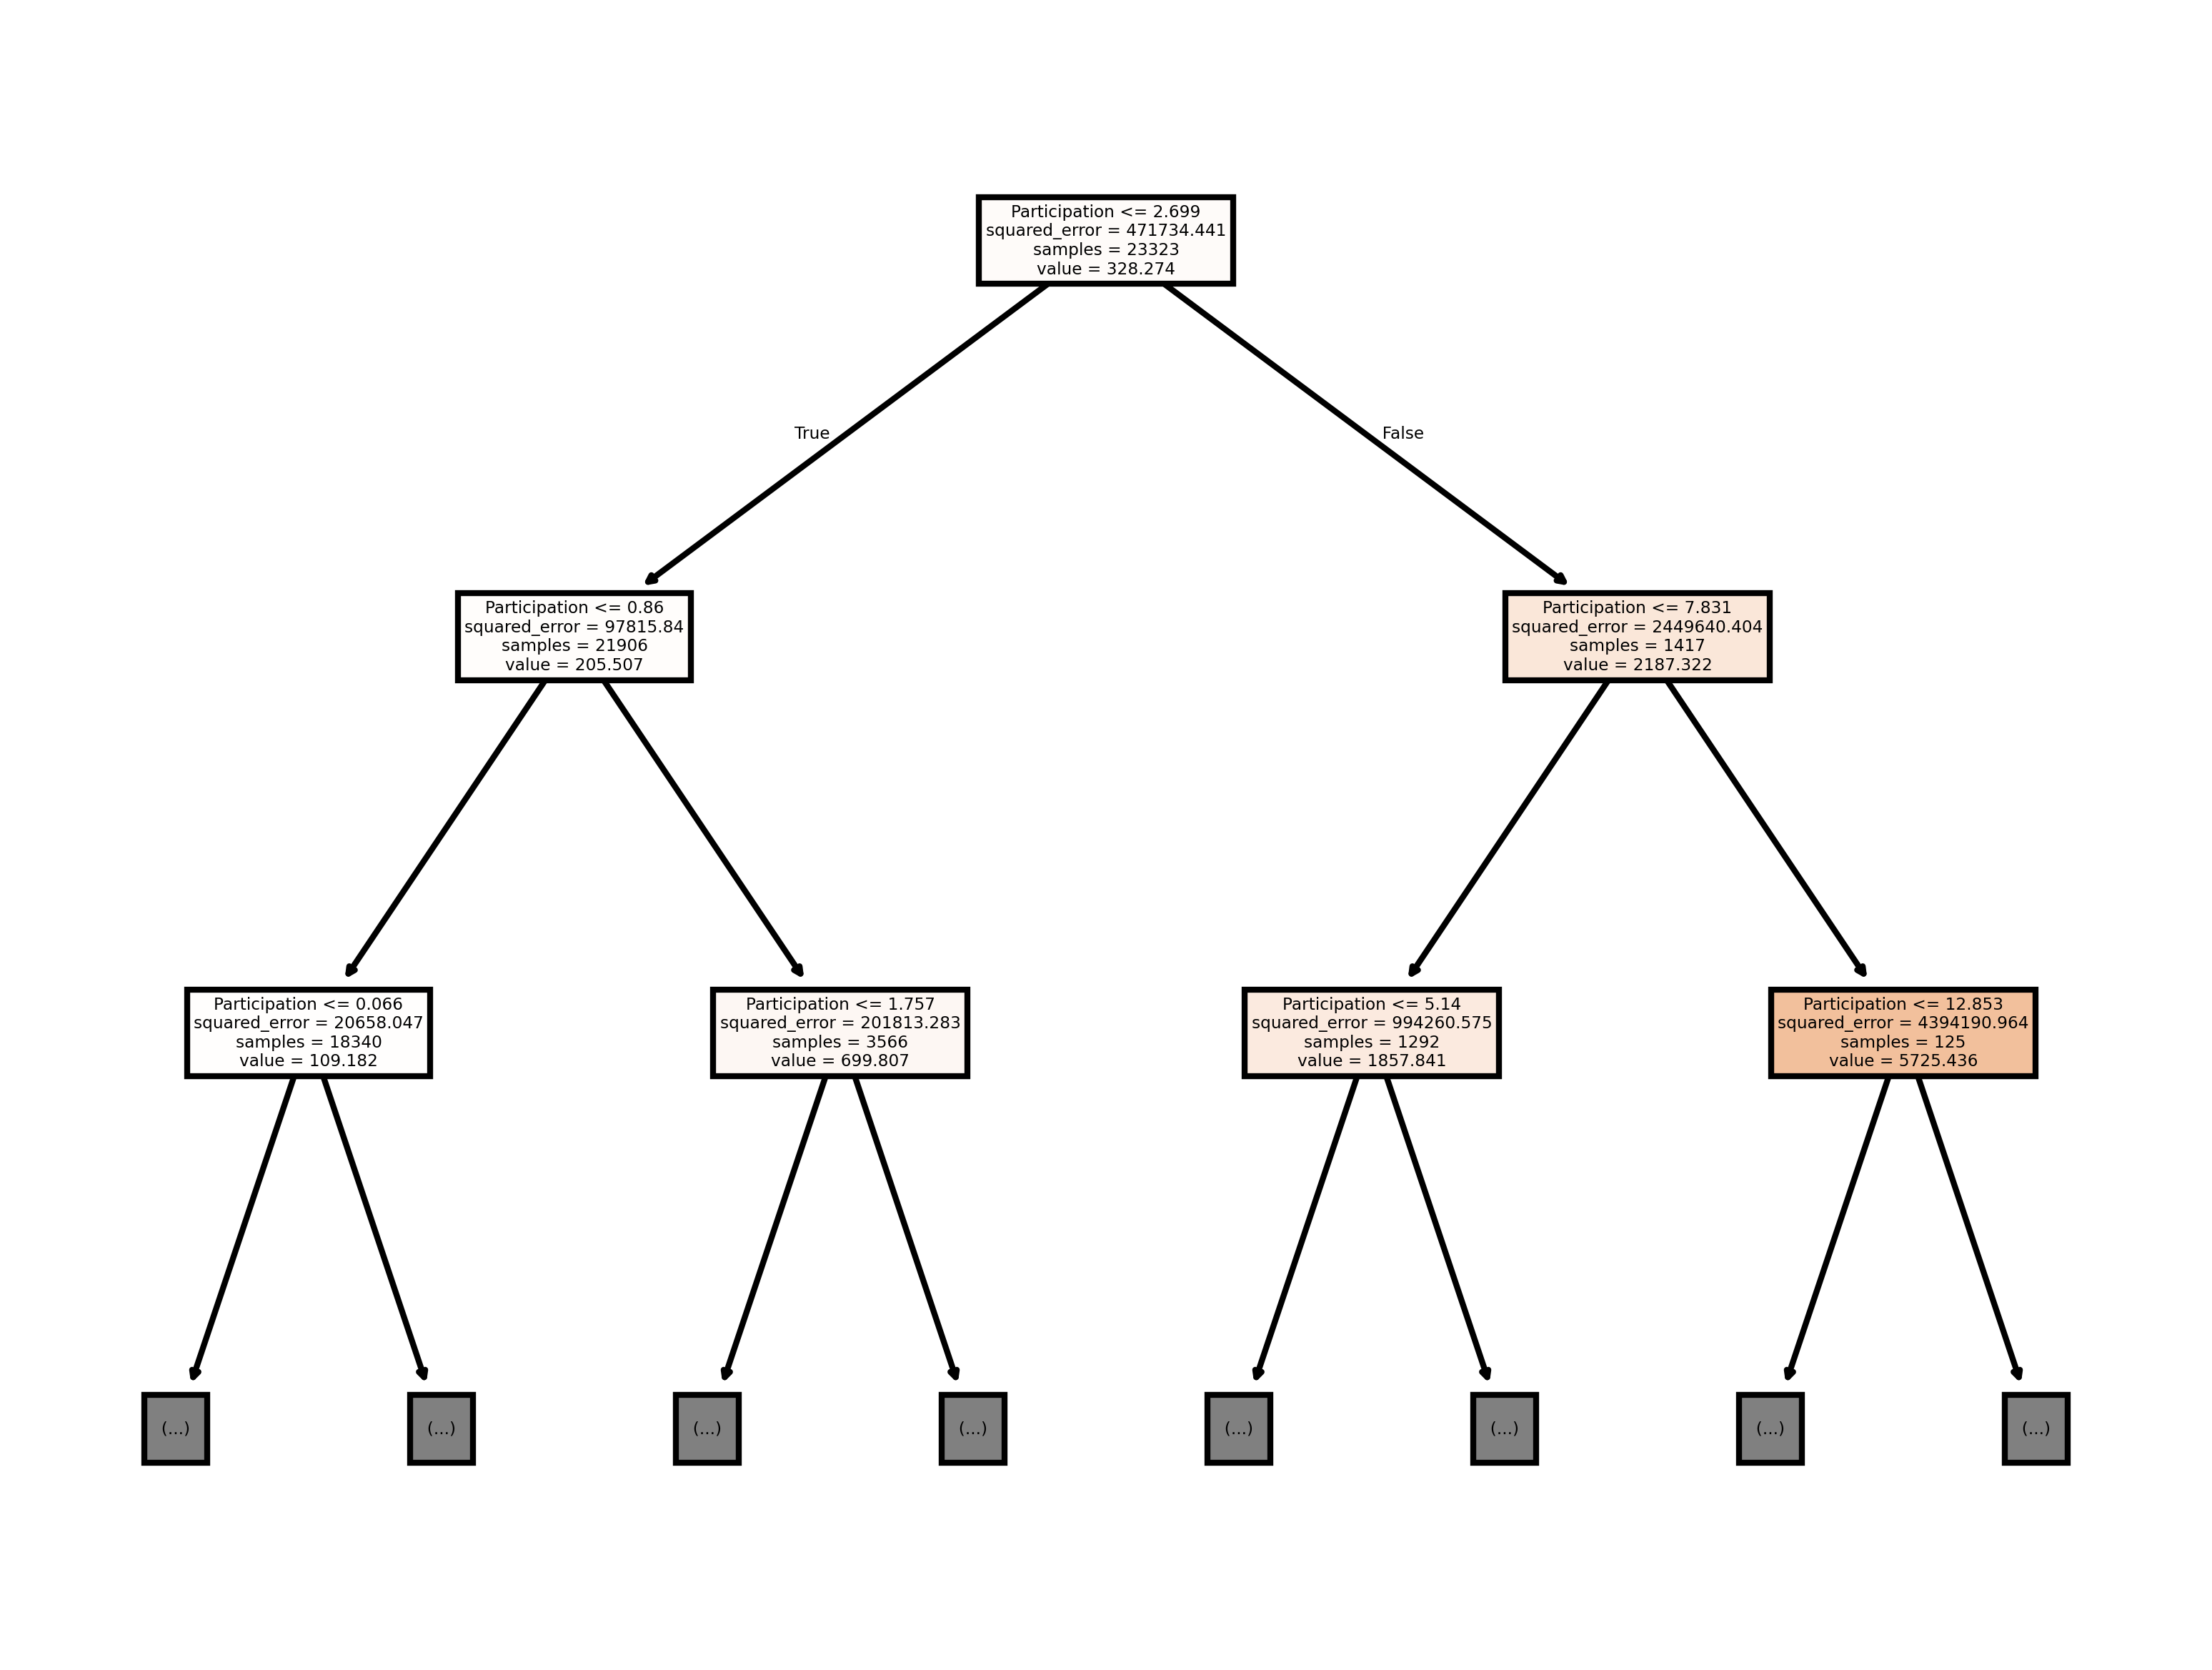

In [31]:
# Get the first decision tree
first_tree = rf_final.estimators_[0]

# Create plot
plt.figure(dpi=600)

# Plot first_tree
plot_tree(first_tree, filled=True, feature_names=X.columns, max_depth=2)

# Display plot
plt.show()

### K-means Clustering

A K-means clustering model was developed to identify distinct student groups based on 'Participation', 'Population Estimate', and 'Achievements'. A new 'X' consisting of these attributes was created for this purpose.

In [32]:
# Scale features using RobustScaler
X_scaled = scaler.fit_transform(
    la_fes_df[["Participation", "Population Estimate", "Achievements"]]
)

A plot using the elbow method was generated to determine the optimal number of clusters for the K-means model.

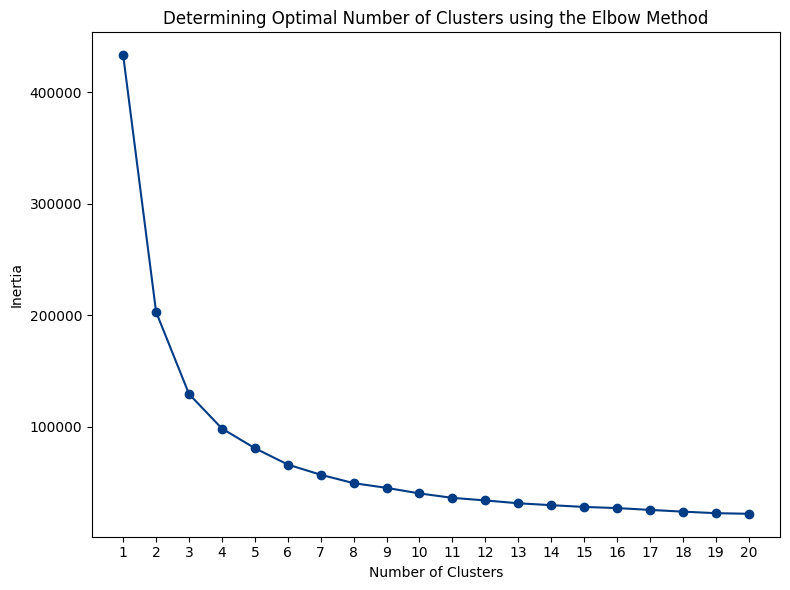

In [33]:
# Create array for storing inertias
inertias = []

# Define number of clusters to test
clusters = range(1, 21)

# Loop through each number of clusters and store inertia
for k in clusters:
    kmeans_test = KMeans(n_clusters=k, random_state=0, init="k-means++")
    kmeans_test.fit(X_scaled)
    inertias.append(kmeans_test.inertia_)

# Create line plot of inertias
plt.figure(figsize=(8, 6))
plt.plot(clusters, inertias, marker="o", color=col_pal["blue"])

# Set xticks
plt.xticks(clusters)

# Add labels
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")

# Add title
plt.title("Determining Optimal Number of Clusters using the Elbow Method")

# Display plot
plt.tight_layout()
plt.show()

Four was determined as the optimal number of clusters. The K-means model was then created using this number of clusters. A 3D plot of the clusters and their centroids was produced of this K-means model.

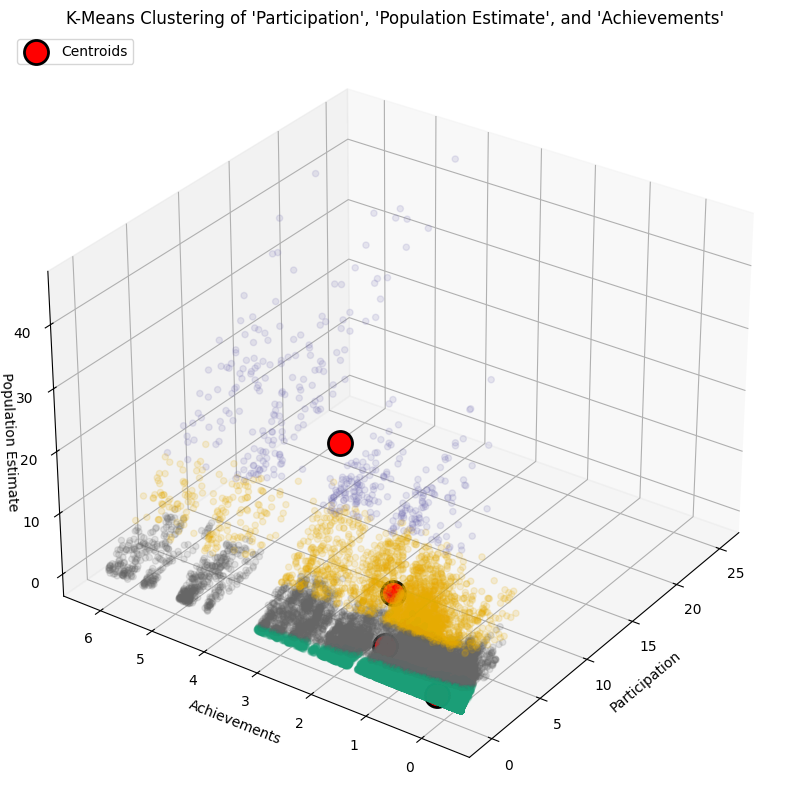

In [34]:
# Create K-Means model with 4 clusters and k-means++
kmeans_final = KMeans(n_clusters=4, random_state=0, init="k-means++")

# Fit the model
kmeans_final.fit(X_scaled)

# Get the centroids
centroids = kmeans_final.cluster_centers_

# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 10))
axs = fig.add_subplot(111, projection="3d")

# Plot the data points
scatter = axs.scatter(
    X_scaled[:, 0],
    X_scaled[:, 1],
    X_scaled[:, 2],
    c=kmeans_final.labels_,
    cmap="Dark2",
    alpha=0.15,
    depthshade=True,
)

# Plot the centroids
axs.scatter(
    centroids[:, 0],
    centroids[:, 1],
    centroids[:, 2],
    s=300,
    c="red",
    marker="o",
    edgecolors="black",
    linewidths=2,
    depthshade=False,
    label="Centroids",
)

# Set axis labels
axs.set_xlabel("Participation")
axs.set_ylabel("Achievements")
axs.set_zlabel("Population Estimate", labelpad=-2)

# Add title
plt.title("K-Means Clustering of 'Participation', 'Population Estimate', and 'Achievements'")

# Rotate the plot for better viewing
axs.view_init(azim=-145, elev=30)

# Add legend
axs.legend(loc="upper left")

# Display plot
plt.tight_layout()
plt.show()

The 3D plot was somewhat difficult to interpret. To ehance interpretability, PCA was used to reduce the number of dimensions to 2, by combining 'Participation' and 'Population Estimate', so that a 2D plot could be created instead.

In [35]:
# Use PCA to combine 'Participation' and 'Population Estimate'
parti_pop_pca = PCA(n_components=1, random_state=0).fit_transform(X_scaled[:, :2])

# Rejoin 'Achievements' with the combined 'Participation' and 'Population Estimate'
X_scaled_pca = np.concatenate((parti_pop_pca, X_scaled[:, 2].reshape(-1, 1)), axis=1)

Produced the final K-means model with the reduced number of dimensions. Created a 2D plot of the resulting final K-means model.

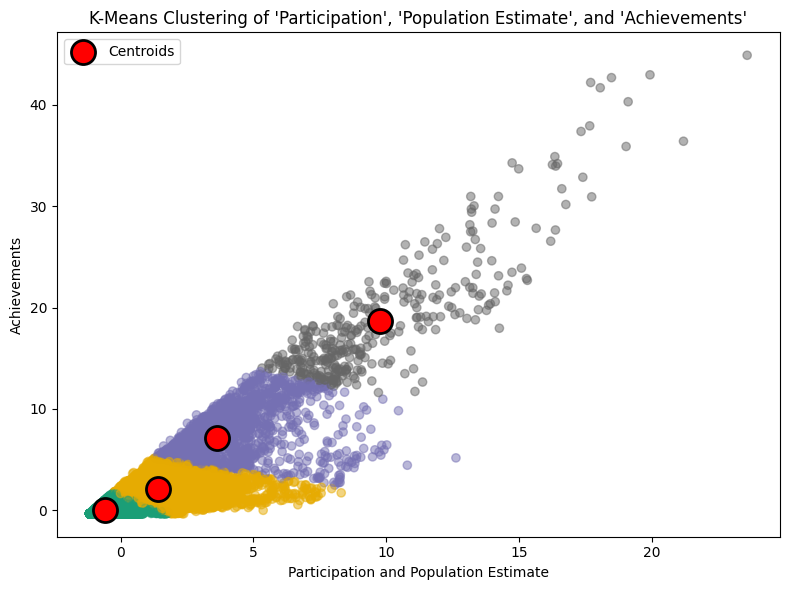

In [36]:
# Create final K-Means model with 4 clusters and k-means++
kmeans_fff = KMeans(n_clusters=4, random_state=0, init="k-means++")

# Fit the model
kmeans_fff.fit(X_scaled_pca)

# Get the centroids
centroids = kmeans_fff.cluster_centers_

# Create a 2D scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(
    X_scaled_pca[:, 0],
    X_scaled_pca[:, 1],
    c=kmeans_fff.labels_,
    cmap="Dark2",
    alpha=0.5,
)

# Plot the centroids
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    s=300,
    c="red",
    marker="o",
    edgecolors="black",
    linewidths=2,
    label="Centroids",
)

# Add labels
plt.xlabel("Participation and Population Estimate")
plt.ylabel("Achievements")

# Add title
plt.title("K-Means Clustering of 'Participation', 'Population Estimate', and 'Achievements'")

# Add legend
plt.legend(loc="upper left")

# Display plot
plt.tight_layout()
plt.show()